In [1]:
# Import standard libraries
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import sys
import os.path
import math
import pybedtools
import hicstraw
from tqdm import tqdm

# Import custom libraries
sys.path.append("..")
import process_hic_contacts_inter as phc

In [2]:
# Specify directories and relevant information
genome_dir = '/home/louiscam/projects/gpcr/data/genome_data/'
arrowhead_dir = '/home/louiscam/projects/gpcr/save/processed_hic_domains/arrowhead/'
raw_hic_dir = '/home/louiscam/projects/gpcr/data/hic_data/IMR90/'
balanced_hic_dir = '/home/louiscam/projects/gpcr/save/processed_hic_data/'
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'
cell_type = 'IMR90'
quality = 'MAPQGE30'
resol = 250000
normalization_list = ['NONE', 'KR']
resolution_list = [5000, 10000, 25000]

In [10]:
# Choose settings
normalization = normalization_list[0]
resol_tad = resolution_list[2]
chrom = 21

# Load genomic information

In [11]:
# Load chromosome size
df_sizes = phc.get_chrom_sizes(genome_dir, resol)
dict_size = {
    (df_sizes.loc[idx, 'chr']): df_sizes.loc[idx, 'size'] for idx in df_sizes.index
}
dict_size_tad = {
    df_sizes.loc[idx, 'chr']: (df_sizes.loc[idx, 'size']//resol_tad)*resol_tad for idx in df_sizes.index
}

In [12]:
# Get chromosome size
chrom_size = (dict_size[str(chrom)]//resol)*resol

# Load Hi-C data

In [13]:
# Load Hi-C
hic = hicstraw.HiCFile(raw_hic_dir+'GSE63525_IMR90_combined_30.hic')
print(f'Genome ID = {hic.getGenomeID()}')
print(f'Resolutions = {hic.getResolutions()}')

Genome ID = hg19
Resolutions = [2500000, 1000000, 500000, 250000, 100000, 50000, 25000, 10000, 5000]


In [25]:
# Pick the counts from the intraX region for a given chromosome
mzd = hic.getMatrixZoomData(
    str(chrom), 
    str(chrom), 
    'observed', 
    normalization, 
    "BP", 
    resol
)
hic_numpy = mzd.getRecordsAsMatrix(0, chrom_size, 0, chrom_size)
hic_df = pd.DataFrame(
    hic_numpy, 
    index=np.arange(0, dict_size_tad[str(chrom)], resol),
    columns=np.arange(0, dict_size_tad[str(chrom)], resol)
)
hic_df.index.name = 'Loci'
hic_df.columns.name = 'Loci'

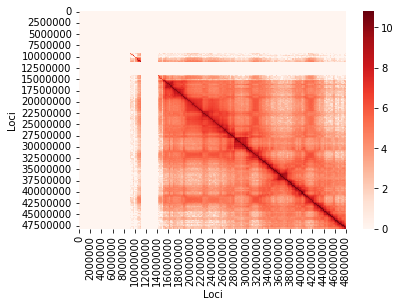

In [26]:
# Plot Hi-C matrix
%matplotlib inline
plt.figure()
sns.heatmap(
    data=np.log(1+hic_df),
    cmap='Reds'
)
plt.show()

# Load TADs for one chromosome

In [27]:
# Load TADs file
fname = arrowhead_dir+f"{normalization}/{resolution}/{chrom}/{resolution}_blocks.bedpe"
tads_df = pd.read_csv(fname, sep='\t', header=0)
tads_df = tads_df.drop(labels=0, axis=0)
tads_df = tads_df.reset_index(drop=True)
tads_df[['x1', 'y1', 'x2', 'y2']] = tads_df[['x1', 'y1', 'x2', 'y2']].astype(int)
tads_df.loc[:, 'length'] = tads_df['x2']-tads_df['x1']
tads_df.head()

,#chr1,x1,x2,chr2,y1,y2,name,score,strand1,strand2,color,score.1,uVarScore,lVarScore,upSign,loSign,length
0,21,19950000,22050000,21.0,19950000,22050000,.,.,.,.,"255,255,0",0.815618,0.112498,0.086357,0.628111,0.546056,2100000
1,21,38525000,38950000,21.0,38525000,38950000,.,.,.,.,"255,255,0",1.146039,0.102075,0.087766,0.666667,0.740741,425000
2,21,30425000,31250000,21.0,30425000,31250000,.,.,.,.,"255,255,0",1.096753,0.118463,0.069908,0.775087,0.702422,825000
3,21,37500000,38425000,21.0,37500000,38425000,.,.,.,.,"255,255,0",1.099515,0.097940,0.090256,0.803324,0.698061,925000
4,21,17225000,18975000,21.0,17225000,18975000,.,.,.,.,"255,255,0",1.086715,0.080356,0.106266,0.650000,0.782540,1750000


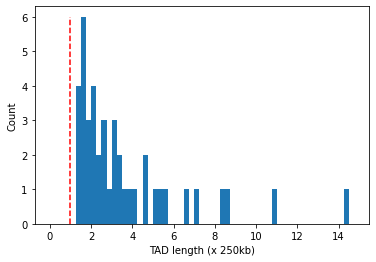

In [28]:
# Distribution of TAD lengths in terms of 250kb
plt.figure()
plt.hist(
    tads_df['length']/resol,
    bins=np.arange(0, 15, 0.25)
)
plt.vlines(x=1, ymin=0, ymax=6, color='red', linestyle='dashed')
plt.xlabel('TAD length (x 250kb)')
plt.ylabel('Count')
plt.show()

# Draw TADs

In [29]:
# Create mask heatmap
tad_map = pd.DataFrame(
    0, 
    index=np.arange(0, dict_size_tad[str(chrom)], resolution), 
    columns=np.arange(0, dict_size_tad[str(chrom)], resolution)
)
for idx in tads_df.index:
    x1 = tads_df.loc[idx, 'x1']
    y1 = tads_df.loc[idx, 'y1']
    x2 = tads_df.loc[idx, 'x2']
    y2 = tads_df.loc[idx, 'y2']
    score = tads_df.loc[idx, 'score.1']
    tad_map.loc[np.arange(x1, x2+1, resolution), np.arange(y1, y2+1, resolution)] = score
tad_map.index.name = 'Loci'
tad_map.columns.name = 'Loci'

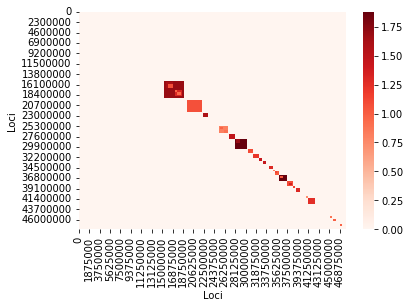

In [33]:
# Visualize heatmap
%matplotlib inline
plt.figure()
sns.heatmap(
    data=tad_map,
    cmap='Reds',
)
plt.show()